<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/DeadTimeEstimatorMDC2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init and cuts definition

In [1]:
!pip install hist
!pip install mplhep
import hist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

h5fileCE='drive/MyDrive/root_files_cry5/trk.mu2e.CeEndpointMix1BBSignal.MDC2020r_perfect_v1_0.h5'
h5fileCRY5='drive/MyDrive/root_files_cry5/trk.mu2e.CosmicCRYOnSpillSignal.MDC2020r_perfect_v1_0.h5'

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)
sys.path.append(main_path+'root_files_cry4')
from utils import Utils
util = Utils()
import math

plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.7
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

Mounted at /content/drive


In [3]:
import mplhep as hep
hep.style.use('ATLAS')  # or ATLAS/LHCb2

In [4]:
!pip install -I git+https://github.com/oksuzian/mu2etools.git
from mu2etools import utils, cuts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/oksuzian/mu2etools.git to /tmp/pip-req-build-0wudlxns
  Running command git clone -q https://github.com/oksuzian/mu2etools.git /tmp/pip-req-build-0wudlxns
  Created wheel for mu2etools: filename=mu2etools-0.0.1-py3-none-any.whl size=5992 sha256=a35d4f4207cc159cba67c414f103e68a90f4c81db7749ad6eb216bb2d52d306c
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ingso0r/wheels/00/92/a8/d2a2c55928a20d8675652a7135b8880f1f4f9b655d8885d452
Successfully built mu2etools


In [5]:
TMIN = -175
TMAX = 50
PMIN_EXT = 90
PMAX_EXT = 140
PMIN_PHY = 103.85
PMAX_PHY = 105.1

#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "(deent_maxr > 450)",
    "(deent_maxr < 680)"
]
cut_tbox = " & ".join(cuts)

#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
#    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)

# Extended momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_EXT,
    "(deent_mom < %f)" % PMAX_EXT
]
cut_extmom = " & ".join(cuts)

# Physics momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_PHY,
    "(deent_mom < %f)" % PMAX_PHY,
]
cut_phymom = " & ".join(cuts)

# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "(deent_maxr > 450)"
]
cut_lbox = " & ".join(cuts)

cut_t0='(de_t0 > 650) & (de_t0 < 1625)'
crv_live_window='((crvinfo_timeWindowStart > 600 & crvinfo_timeWindowStart < 1650) | crvinfo_timeWindowStart<1)'

crv_time = "( crvinfo_dT < %d | crvinfo_dT > %d)" % (TMIN, TMAX)
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom
cut_phymom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_phymom
cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue

cut_extmom_notiming = cut_extmom
cut_extmom = cut_extmom+" & " + cut_t0+" & " + crv_live_window
cut_current = cut_extmom+" & "+crv_time

#Load dataframe

In [6]:
dfCRY5 = pd.read_hdf(h5fileCRY5, mode='r').query('lyield==%i' % 17000)
dfCE = pd.read_hdf(h5fileCE, mode='r', key='CE').query('lyield==%i' % 17000)

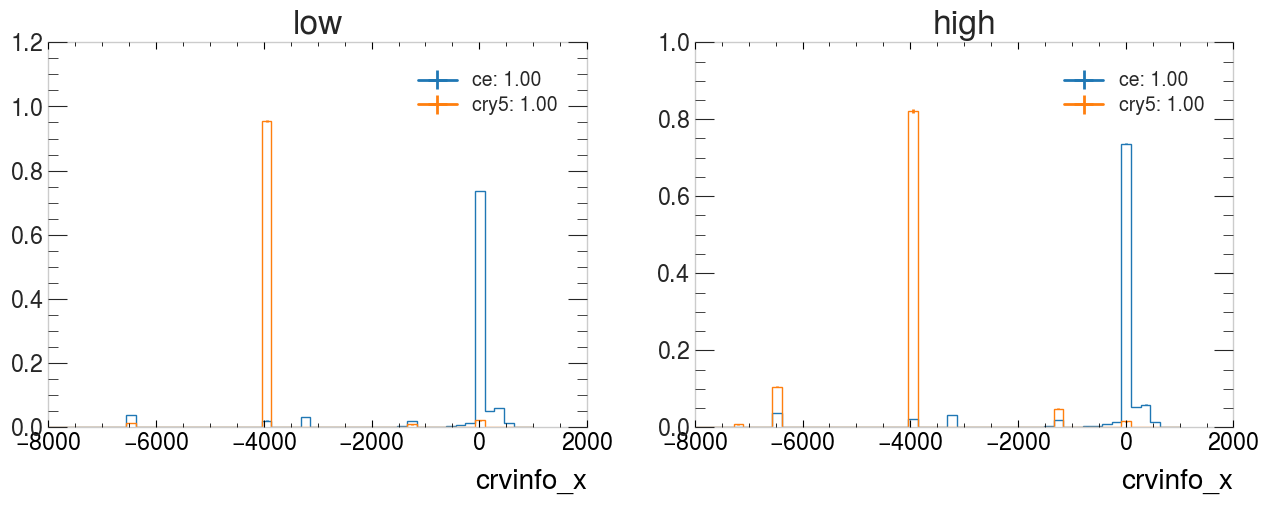

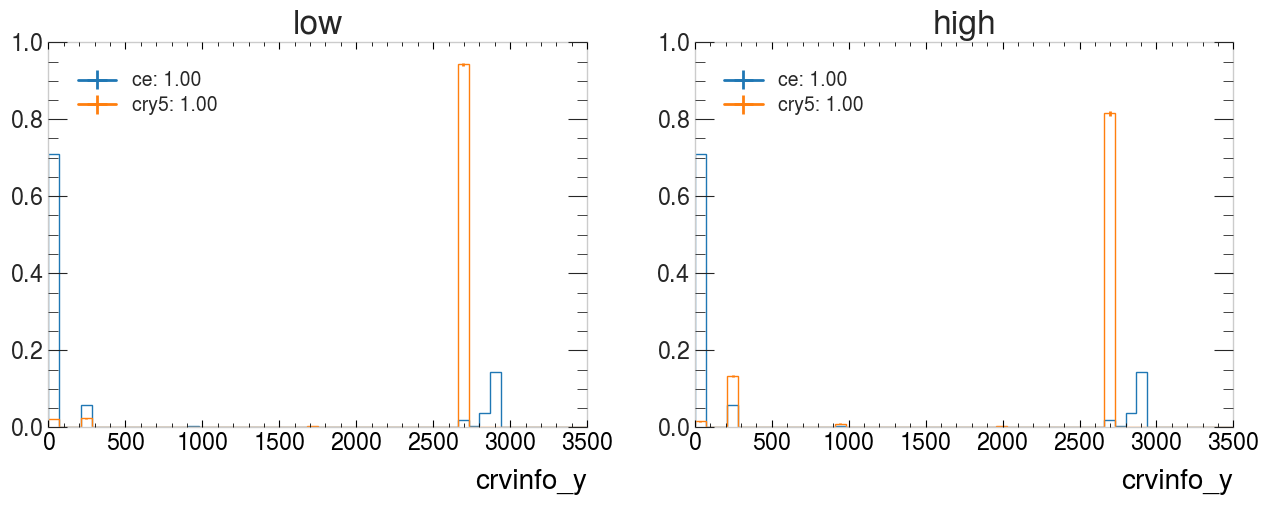

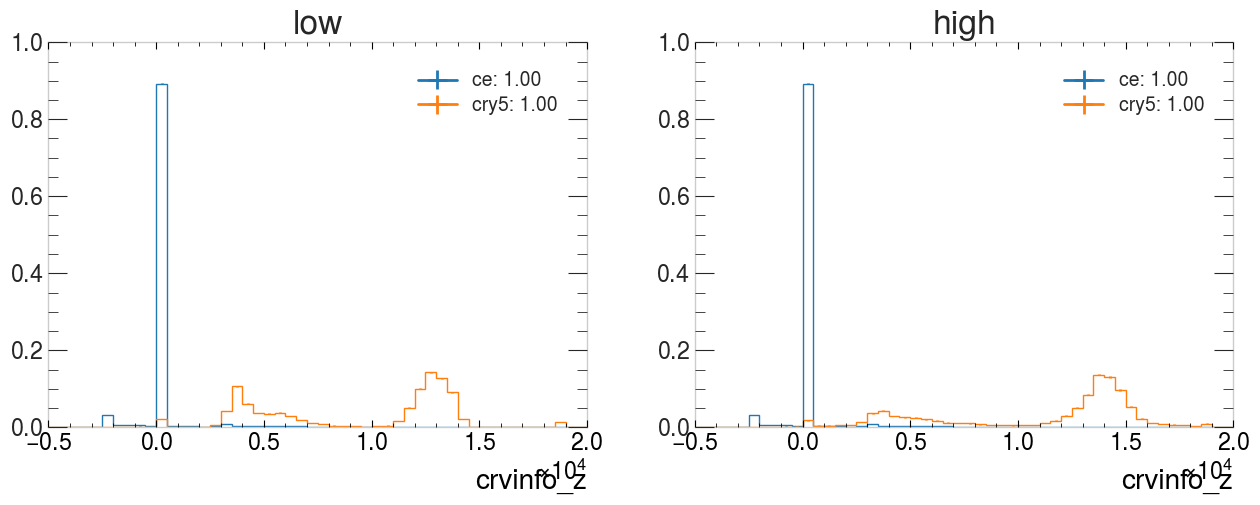

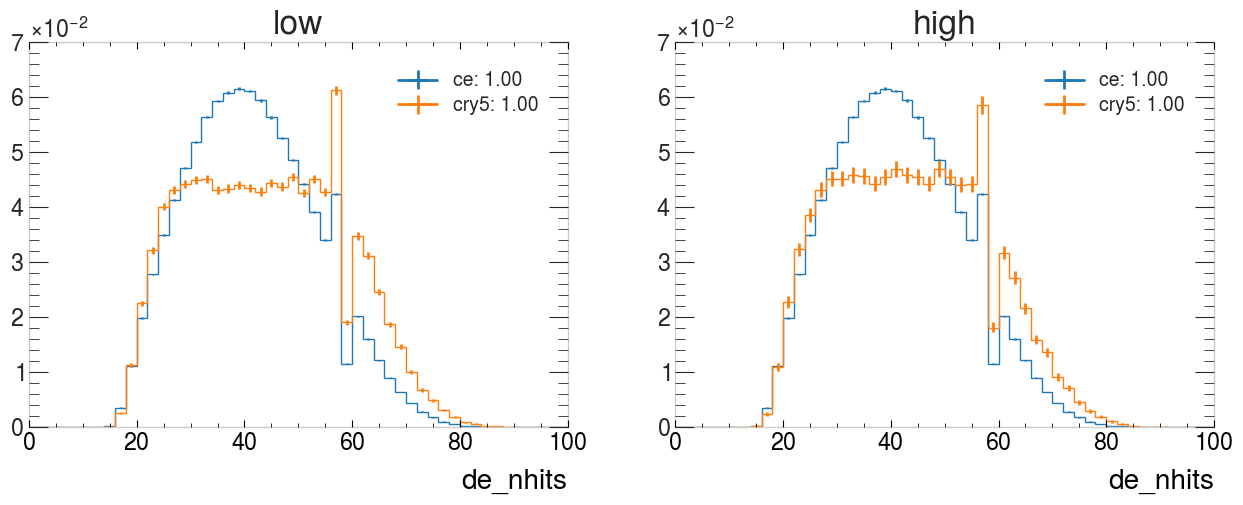

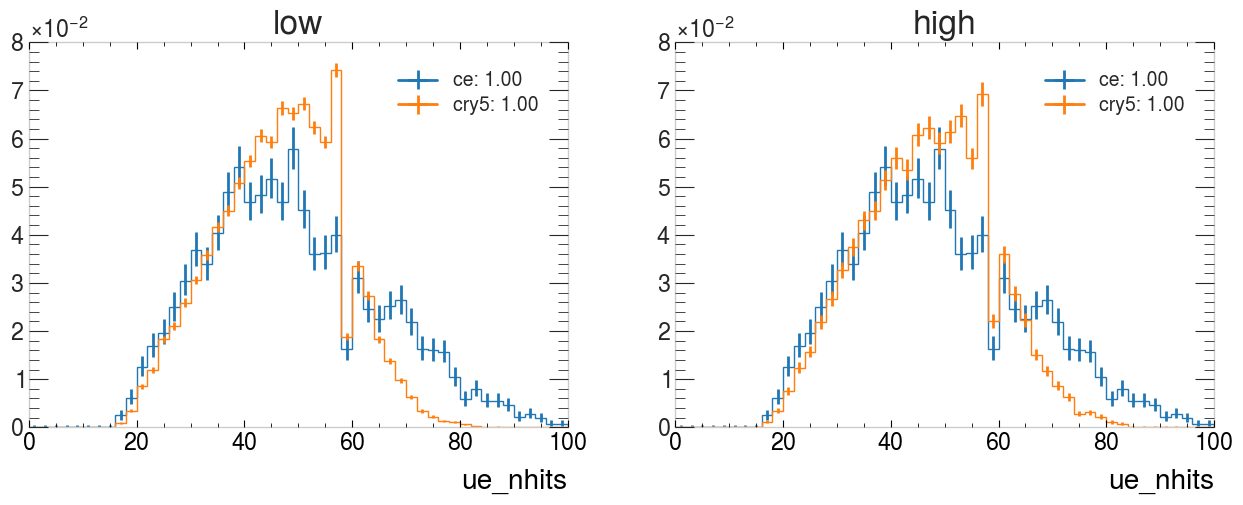

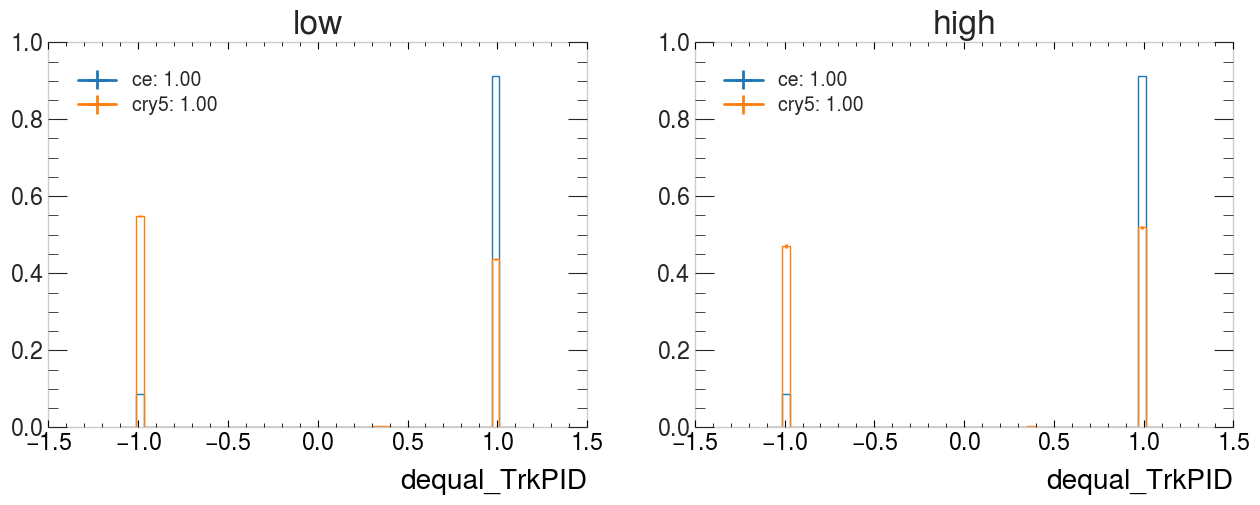

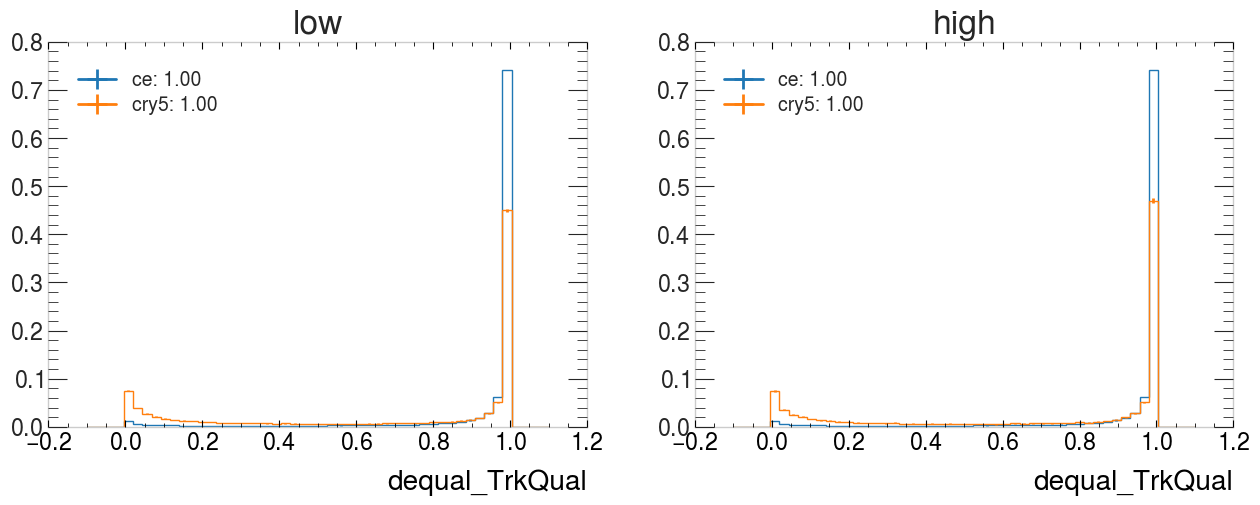

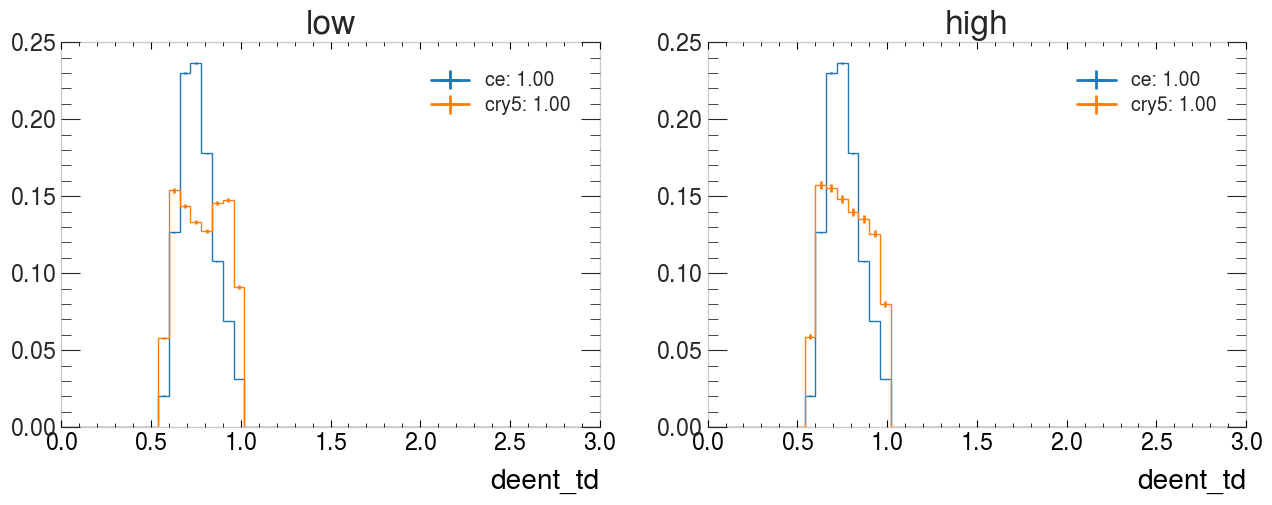

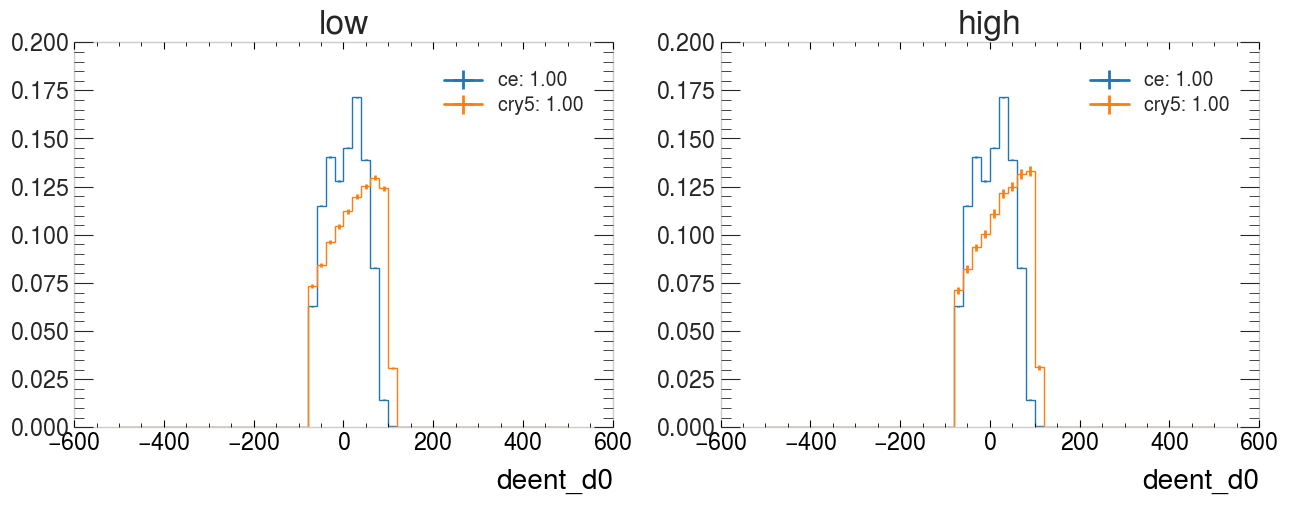

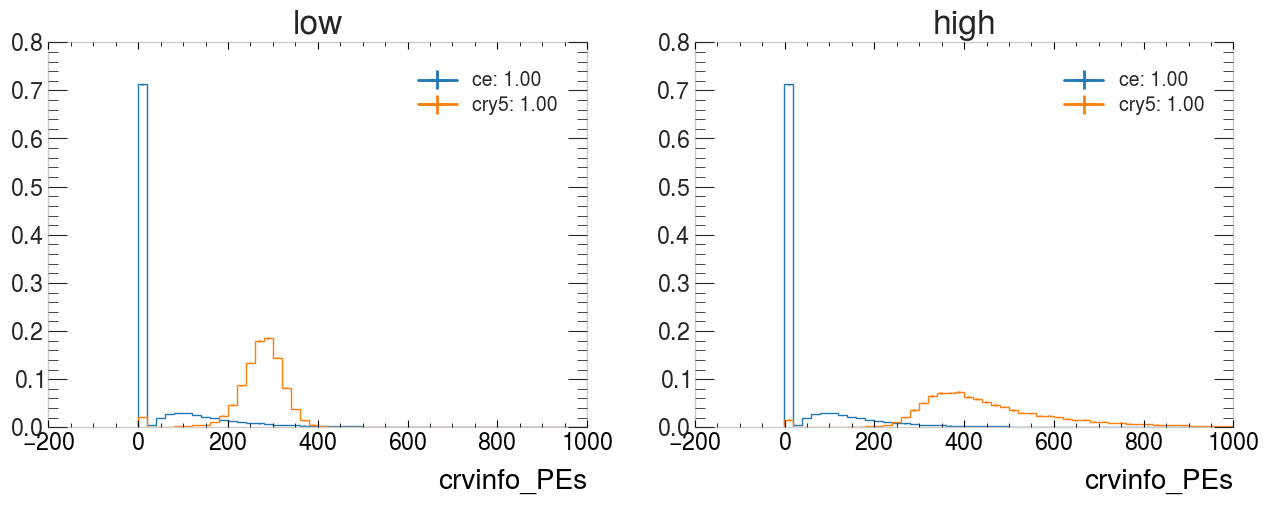

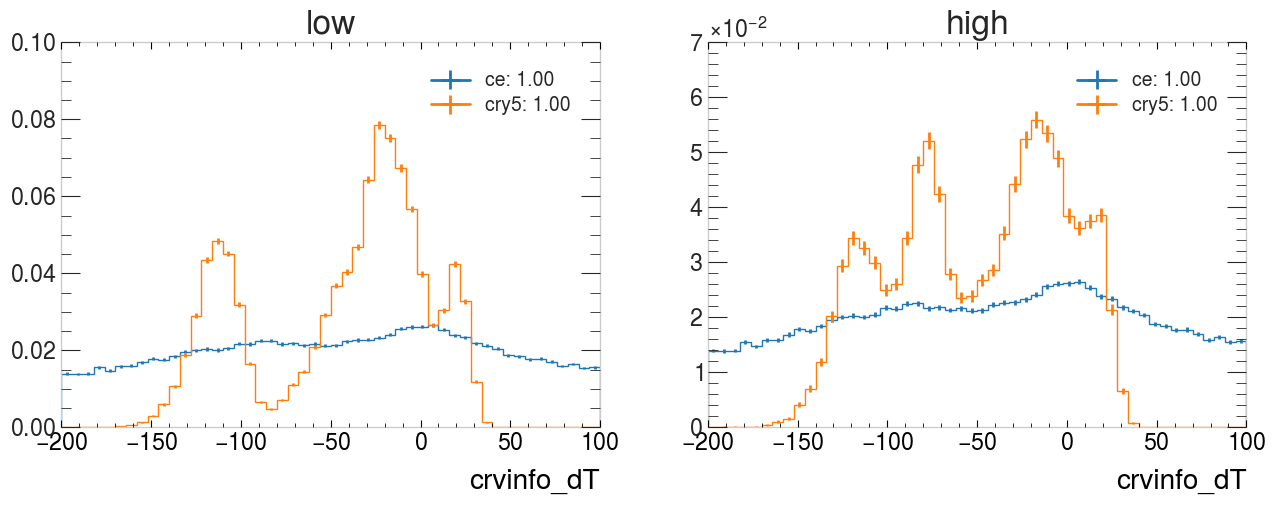

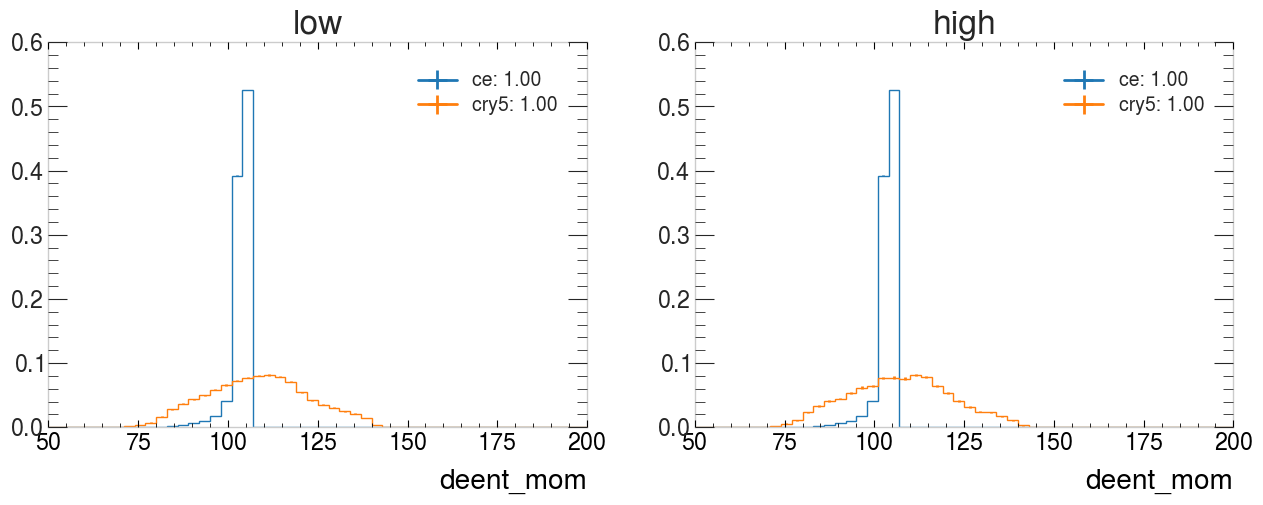

In [7]:
var_dict = utils.getVarList('allCRY5')

utils.LIVETIME_LO_CRY5 = 1.15E8*780/907
utils.LIVETIME_HI_CRY5 = 3.83E6*190/323

nLTimesCRY5 = [utils.LIVETIME_LO_CRY5/utils.LIVETIME_MU2E, utils.LIVETIME_HI_CRY5/utils.LIVETIME_MU2E]

title=["low", "high"]

for var in var_dict.keys():
  if "deent_z0" in var or "deent_om" in var: 
    continue

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
  h = hist.Hist(
    hist.axis.StrCategory(["ce", "cry5"], name="cat"),
    hist.axis.Regular(50, var_dict[var][0], var_dict[var][1], name="x", label="w [units]"),
    hist.storage.Weight(),
  ) 

  cut_tmp='(deent_mom > 100) & (deent_mom < 110)'
  for i in [0,1]:
    h.reset()
    h.fill(cat="ce", x=dfCE.query(cut_tbox + '& is_high==-1')[var].to_numpy())
    h.fill(cat="cry5", x=dfCRY5.query(cut_tbox + '& is_high==%d'%i)[var].to_numpy())

    h_tmp=(h["ce", :] / h["ce", :].counts().sum())
    h_tmp.plot(ax=axes[i], label='ce: %.2f'%h_tmp.counts().sum())
    h_tmp=(h["cry5", :] / h["cry5", :].counts().sum())
    h_tmp.plot(ax=axes[i], label='cry5: %.2f'%h_tmp.counts().sum())

    axes[i].set_xlabel(var)
    axes[i].set_title(title[i])
    axes[i].legend()


In [8]:
df = dfCE

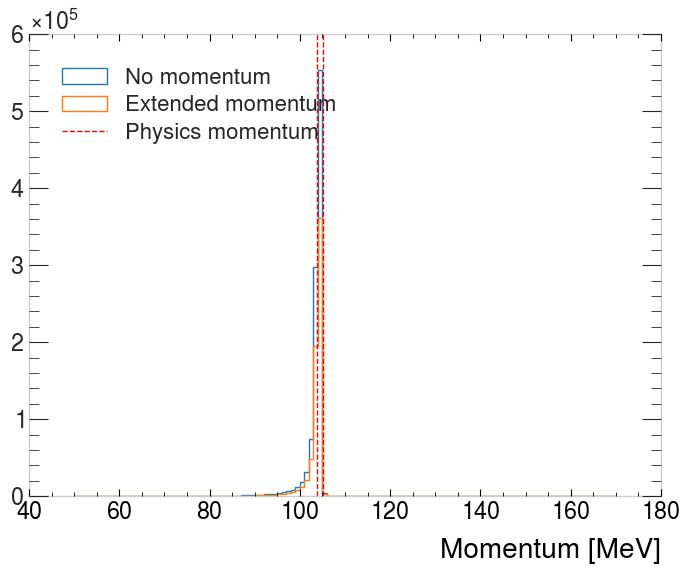

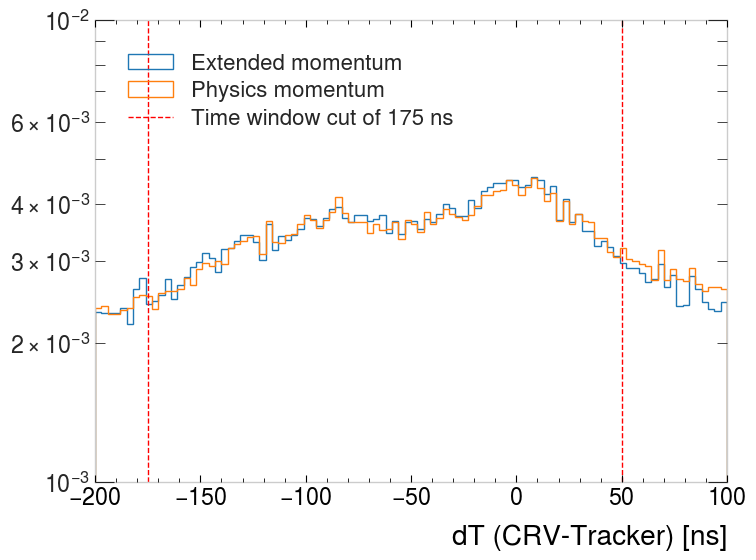

In [9]:
neve_extmom = len(df.query(cut_extmom))
neve_physmom = len(df.query(cut_phymom))
mom_scale = neve_extmom/neve_physmom
label = r'$\frac{P_{ext}}{P_{phy}} = %.1f$' % mom_scale
_, bins, _ = plt.hist(df.query(cut_nomom)['deent_mom'], bins=120, range=[50, 170], histtype='step', label='No momentum');
plt.hist(df.query(cut_extmom)['deent_mom'], bins=bins, histtype='step', label='Extended momentum');
plt.axvline(PMIN_PHY, color='r', linestyle='--', linewidth=1)
plt.axvline(PMAX_PHY, color='r', linestyle='--', label='Physics momentum', linewidth=1)
plt.legend(loc='upper left', prop={'size': 16})
plt.xlabel('Momentum [MeV]')

plt.figure()
plt.hist(df.query(cut_extmom)['crvinfo_dT'], bins=100, range=(-200, 100), histtype='step', density=True, label='Extended momentum');
plt.hist(df.query(cut_phymom)['crvinfo_dT'], bins=100, range=(-200, 100), histtype='step', density=True, label='Physics momentum');
plt.axvline(TMIN, color='r', linestyle='--', linewidth=1)
plt.axvline(TMAX, color='r', linestyle='--', linewidth=1, label='Time window cut of 175 ns')
plt.yscale('log')
plt.xlabel('dT (CRV-Tracker) [ns]');
plt.legend(loc='upper left', prop={'size': 16})

#Background estimation: production sources

In [10]:
def plot_background(cut_query, title, altitude_scale, log_scale=True, make_plot=True):

  lyield_scale=0.001726
  bg_ave = []
  pe_ave = []
  bg_err = []

  for ly in range(7000,17001,2000):
    bg = utils.getNormBackground(df, cut_query+" & lyield =="+str(ly), mom_scale, utils.LIVETIME_LO_CRY5, utils.LIVETIME_HI_CRY5)
    bg_ave.append(bg[0]*altitude_scale)
    pe_ave.append(ly*lyield_scale)
    bg_err.append(bg[1]*math.sqrt(altitude_scale))
    print("PE: %.1f, bg: %3.4f, err: %3.4f" % (ly*lyield_scale, bg[0]*altitude_scale, bg[1]))

  if make_plot:
    plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.k');
    plt.title(title)
  if log_scale:
    plt.yscale('log')
  return (bg_ave, pe_ave, bg_err)

In [11]:
cut_extmom

'(de_status > 0) & (deent_td > 0.577350) & (deent_td < 1.000) & (deent_d0 > -80) & (deent_d0 < 105) & (deent_maxr > 450) & (deent_maxr < 680) & (dequal_TrkQual > 0.8) & (ue_status <= 0) & (deent_mom > 90.000000) & (deent_mom < 140.000000) & (de_t0 > 650) & (de_t0 < 1625) & ((crvinfo_timeWindowStart > 600 & crvinfo_timeWindowStart < 1650) | crvinfo_timeWindowStart<1)'

In [12]:
cut_current

'(de_status > 0) & (deent_td > 0.577350) & (deent_td < 1.000) & (deent_d0 > -80) & (deent_d0 < 105) & (deent_maxr > 450) & (deent_maxr < 680) & (dequal_TrkQual > 0.8) & (ue_status <= 0) & (deent_mom > 90.000000) & (deent_mom < 140.000000) & (de_t0 > 650) & (de_t0 < 1625) & ((crvinfo_timeWindowStart > 600 & crvinfo_timeWindowStart < 1650) | crvinfo_timeWindowStart<1) & ( crvinfo_dT < -175 | crvinfo_dT > 50)'

In [13]:
df.query(cut_extmom)['de_t0']

entry
0           934.937561
2          1155.732788
3           777.296082
4          1288.612183
7          1262.516968
              ...     
1359854     927.866821
1359855     790.373047
1359856     732.020203
1359858     793.995483
1359865    1551.122070
Name: de_t0, Length: 671803, dtype: float32

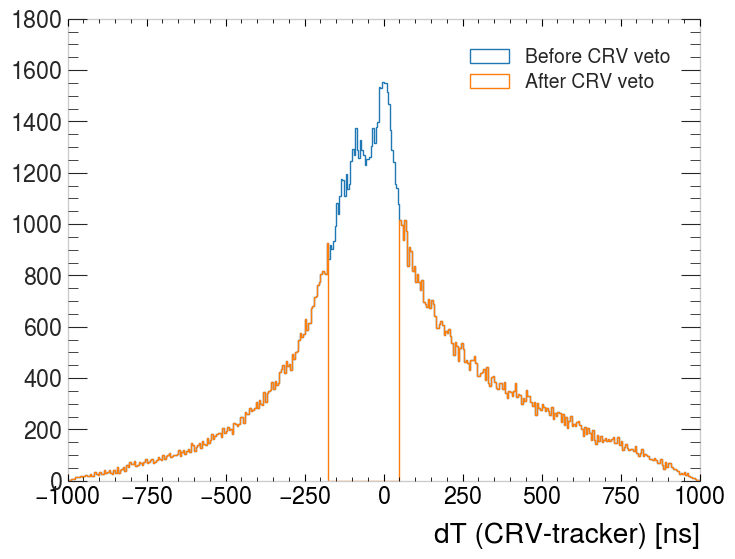

In [14]:
plt.hist(df.query(cut_extmom+'& crvinfo_timeWindowStart>0')['crvinfo_dT'], bins=400, range=(-1000, 1000), histtype='step', label='Before CRV veto');
plt.hist(df.query(cut_current+'& crvinfo_timeWindowStart>0')['crvinfo_dT'], bins=400, range=(-1000, 1000), histtype='step', label='After CRV veto');
plt.xlabel('dT (CRV-tracker) [ns]')
plt.legend();

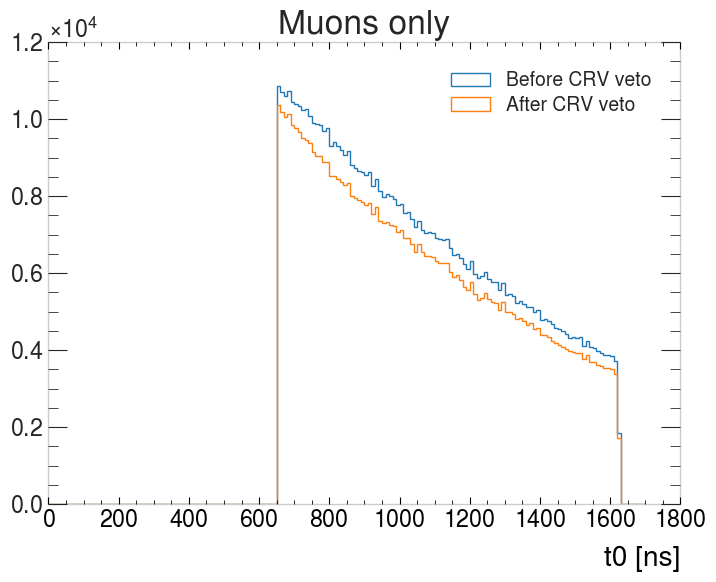

In [15]:
plt.hist(df.query(cut_extmom+" & " + cut_t0+" & " + crv_live_window)['de_t0'], bins=170, range=(0, 1700), histtype='step', label='Before CRV veto');
plt.hist(df.query(cut_current+" & " + cut_t0+" & " + crv_live_window)['de_t0'], bins=170, range=(0, 1700), histtype='step', label='After CRV veto');
plt.xlabel('t0 [ns]')
plt.title('Muons only')
plt.legend();

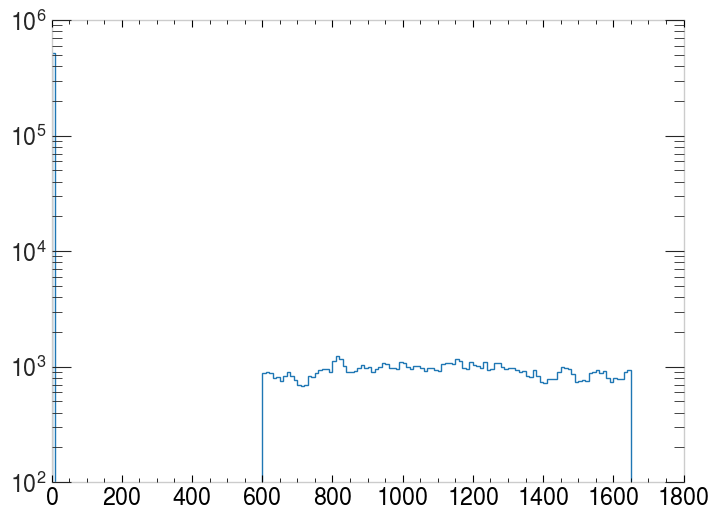

In [16]:
plt.hist(df.query(cut_current+" & " + cut_t0)['crvinfo_timeWindowStart'], bins=170, range=(0, 1700), histtype='step', label='After CRV cuts');
plt.yscale('log')

(600.0, 1750.0)

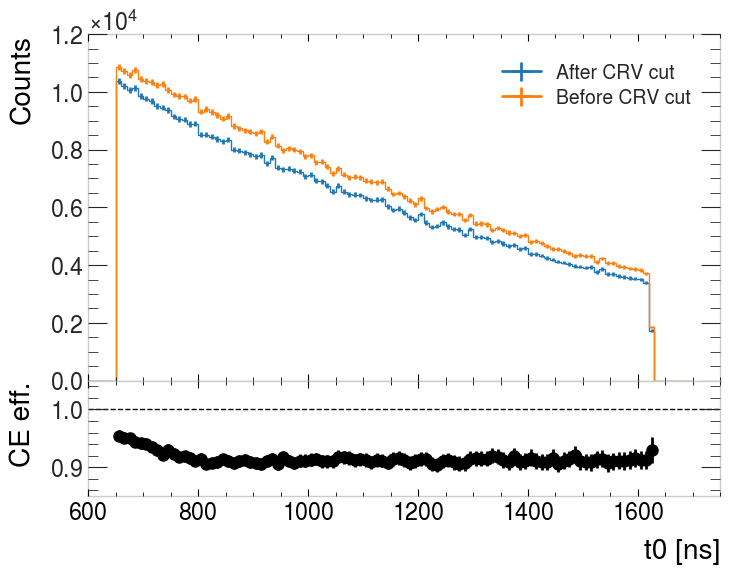

In [17]:
h = hist.Hist(
  hist.axis.StrCategory(["all", "cut", "all", "cut"], name="cat"),
  hist.axis.Regular(130, 400, 1700, name="x", label="t0 [ns]"),
  hist.storage.Weight(),
) 

h.fill(cat="all", x=df.query(cut_extmom)['de_t0'].to_numpy())
h.fill(cat="cut", x=df.query(cut_current)['de_t0'].to_numpy());

fig = plt.figure()
h["cut", :].plot_ratio(h["all", :], rp_num_label="After CRV cut", rp_denom_label="Before CRV cut", rp_ylim=[0.85, 1.05], rp_uncert_draw_type='line');
fig.get_axes()[1].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
fig.get_axes()[1].set_ylabel('CE eff.')
fig.get_axes()[1].set_xlim(600,1750)

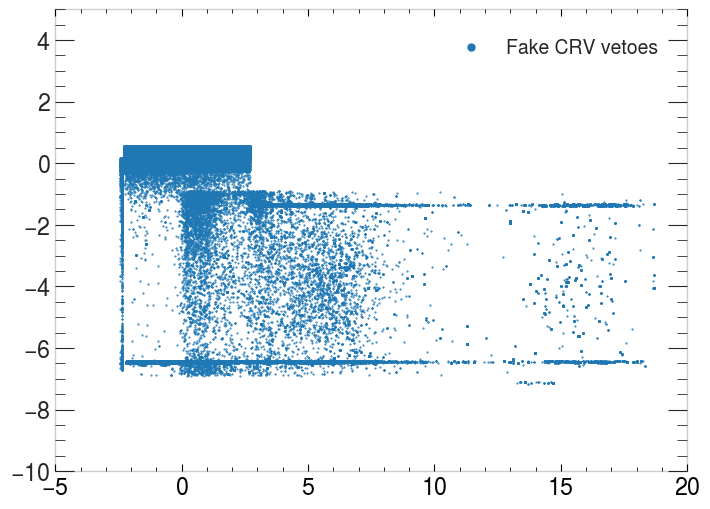

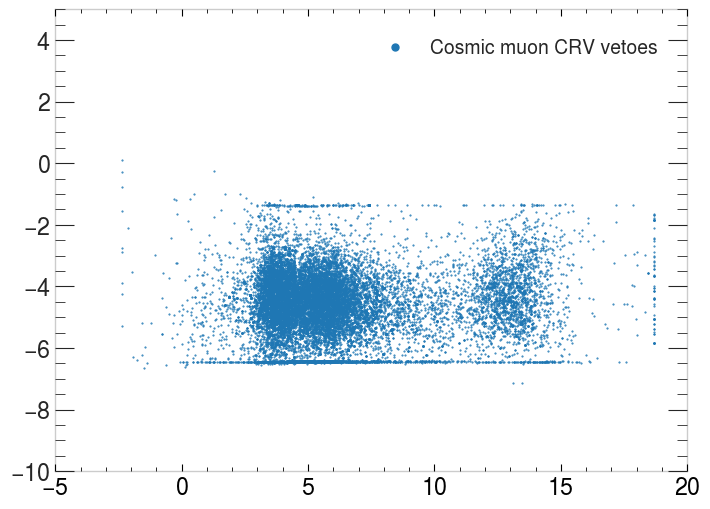

In [18]:
plt.plot(df.query(cut_extmom)['crvsummarymc_z']/1000, df.query(cut_extmom)['crvsummarymc_x']/1000, '.', label='Fake CRV vetoes', markersize=1.0)
plt.xlim(-5,20)
plt.ylim(-10,5)
plt.legend();
lgnd = plt.legend()
lgnd.legendHandles[0].set_markersize(10)

plt.figure()
plt.plot(dfCRY5.query(cut_extmom)['crvsummarymc_z']/1000, dfCRY5.query(cut_extmom)['crvsummarymc_x']/1000, '.', label='Cosmic muon CRV vetoes', markersize=1.)
plt.xlim(-5,20)
plt.ylim(-10,5)
plt.legend();
lgnd = plt.legend()
lgnd.legendHandles[0].set_markersize(10)

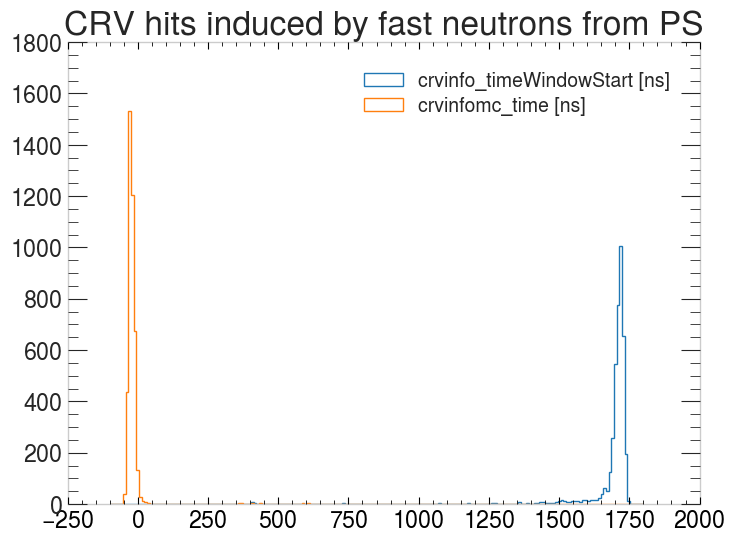

In [19]:
plt.hist(df.query('crvinfomc_parentPdgId==2112 & crvinfomc_parentZ<-5000 &'+cut_t0)['crvinfo_timeWindowStart'], histtype='step', bins=200, range=(-100, 1800), label='crvinfo_timeWindowStart [ns]');
plt.hist(df.query('crvinfomc_parentPdgId==2112 & crvinfomc_parentZ<-5000 &'+cut_t0)['crvinfomc_time'], histtype='step', bins=200, range=(-100, 1800), label='crvinfomc_time [ns]');
plt.title('CRV hits induced by fast neutrons from PS')
plt.legend();

Text(1, 0, 'CRV t0 [ns]')

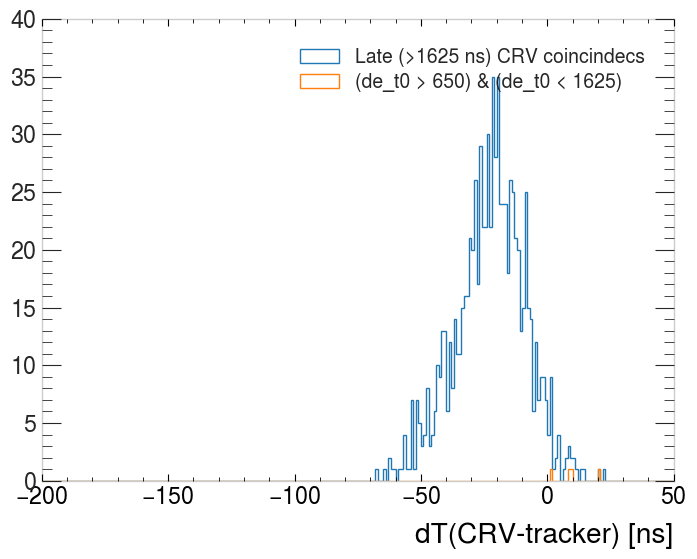

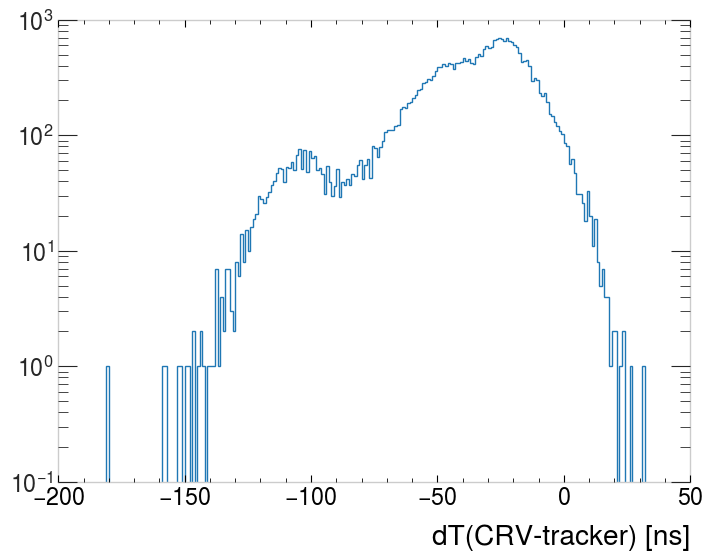

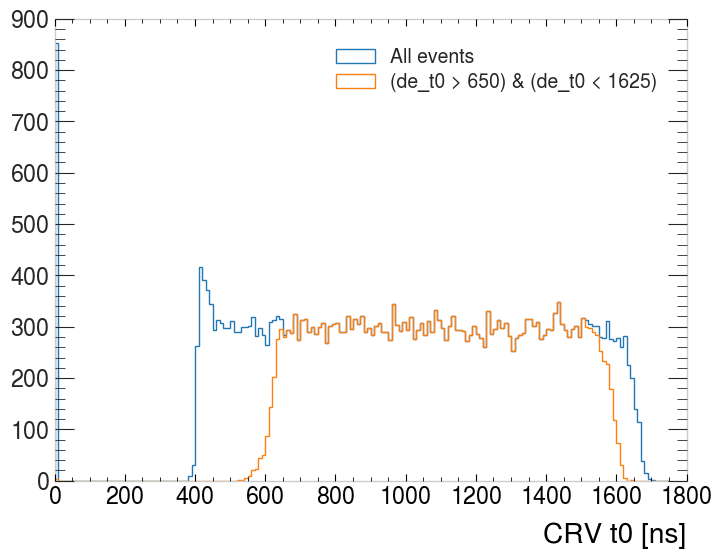

In [20]:
cut_tmp=cut_extmom_notiming+'& crvsummarymc_z>-9999'
plt.hist(dfCRY5.query(cut_tmp+'& crvinfo_timeWindowStart>1625')['crvinfo_dT'], histtype='step', bins=250, range=(-200, 50), label='Late (>1625 ns) CRV coincindecs');
plt.hist(dfCRY5.query(cut_tmp+'& crvinfo_timeWindowStart>1625'+'&'+cut_t0)['crvinfo_dT'], histtype='step', bins=250, range=(-200, 50), label=cut_t0);
plt.legend()
plt.xlabel('dT(CRV-tracker) [ns]')

plt.figure()
plt.hist(dfCRY5.query(cut_tmp+'&'+cut_t0)['crvinfo_dT'], histtype='step', bins=250, range=(-200, 50));
plt.xlabel('dT(CRV-tracker) [ns]')
plt.yscale('log')

plt.figure()
plt.hist(dfCRY5.query(cut_tmp)['crvinfo_timeWindowStart'], histtype='step', bins=175, range=(0, 1750), label='All events');
plt.hist(dfCRY5.query(cut_tmp+'&'+cut_t0)['crvinfo_timeWindowStart'], histtype='step', bins=175, range=(0, 1750), label=cut_t0);
plt.legend()
plt.xlabel('CRV t0 [ns]')




In [21]:
df_tmp = df.query('crvinfo_PEs>0 & '+ cut_t0).groupby(['crvinfomc_x',	'crvinfomc_y', 'crvinfomc_z', 'crvinfomc_parentX', 'crvinfomc_parentZ', 'crvinfomc_parentPdgId', 'crvinfomc_gparentX', 'crvinfomc_gparentZ', 'crvinfomc_gparentPdgId', 'crvinfomc_pdgId', 'crvinfomc_time']).size().reset_index()
df_tmp.rename(columns={0:'sampling_factor'}, inplace=True)

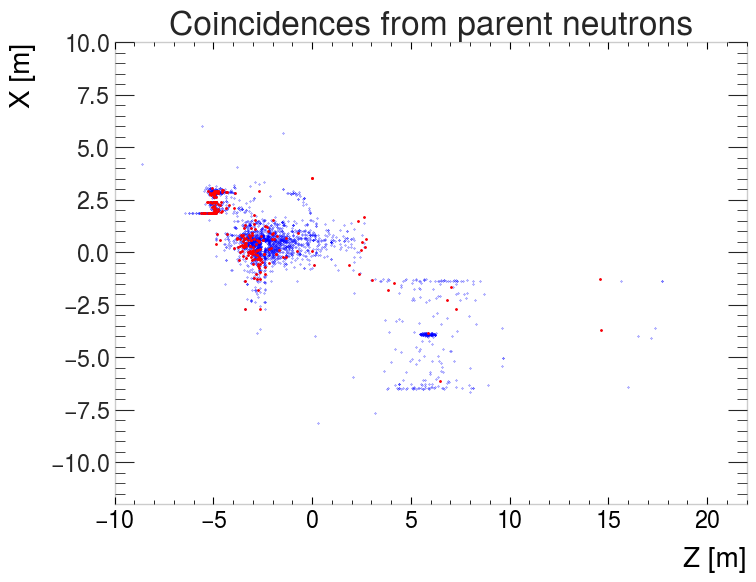

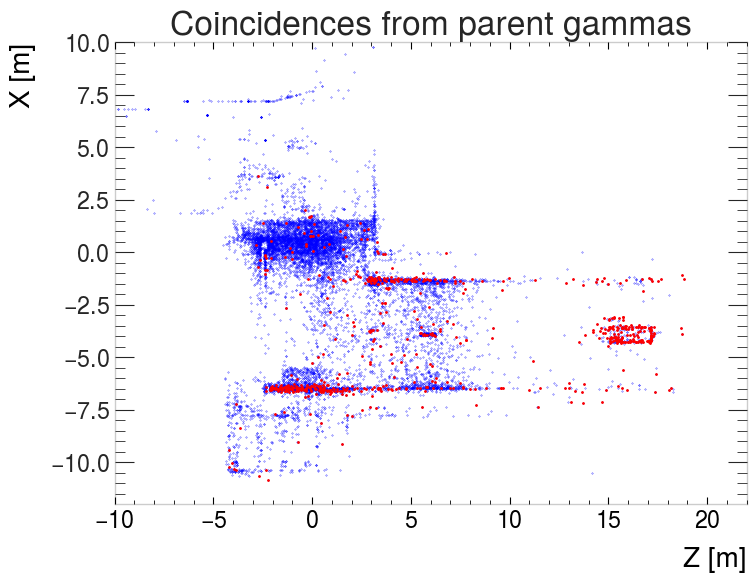

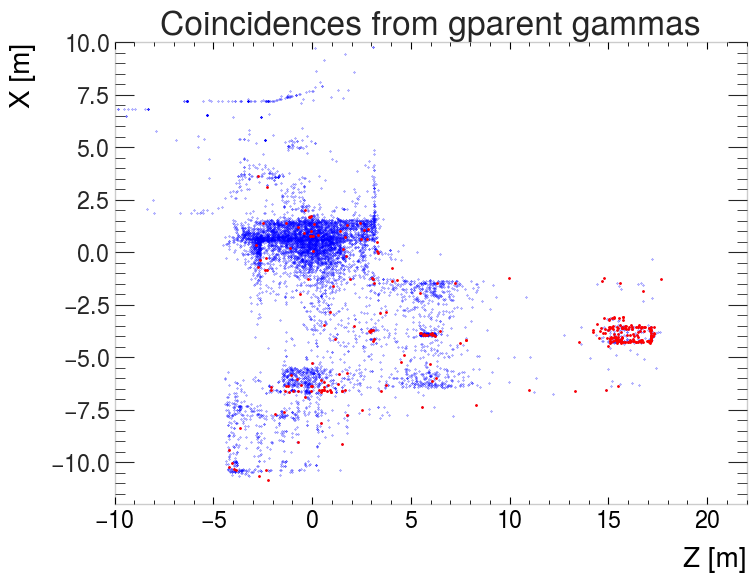

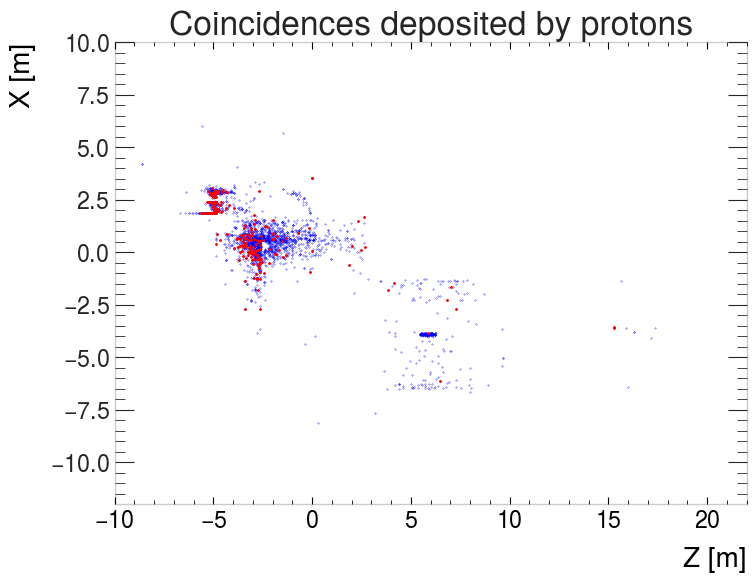

In [22]:
df_tmp2 = df_tmp.query('crvinfomc_parentPdgId==2112 & sampling_factor>1 & crvinfomc_time>-100')
plt.plot(df_tmp2['crvinfomc_parentZ']/1000, df_tmp2['crvinfomc_parentX']/1000, '.b', markersize=0.5);
#plt.hist2d(df_tmp2['crvinfomc_parentZ'], df_tmp2['crvinfomc_parentX'], bins = 1000, norm=mpl.colors.LogNorm(), cmap=plt.cm.jet);
df_tmp2 = df_tmp.query('crvinfomc_parentPdgId==2112 & sampling_factor>10 & crvinfomc_time>-100')
plt.plot(df_tmp2['crvinfomc_parentZ']/1000, df_tmp2['crvinfomc_parentX']/1000, '.r', markersize=2.0);
plt.ylim(-12, 10)
plt.xlim(-10, 22)
plt.title('Coincidences from parent neutrons')
plt.xlabel('Z [m]')
plt.ylabel('X [m]')

plt.figure()
df_tmp2 = df_tmp.query('crvinfomc_parentPdgId==22 & sampling_factor>1')
plt.plot(df_tmp2['crvinfomc_parentZ']/1000, df_tmp2['crvinfomc_parentX']/1000, '.b', markersize=0.5);
df_tmp2 = df_tmp.query('crvinfomc_parentPdgId==22 & sampling_factor>10')
plt.plot(df_tmp2['crvinfomc_parentZ']/1000, df_tmp2['crvinfomc_parentX']/1000, '.r', markersize=2.0);
plt.ylim(-12, 10)
plt.xlim(-10, 22)
plt.title('Coincidences from parent gammas')
plt.xlabel('Z [m]')
plt.ylabel('X [m]')

plt.figure()
df_tmp2 = df_tmp.query('crvinfomc_gparentPdgId==22 & sampling_factor>1')
plt.plot(df_tmp2['crvinfomc_gparentZ']/1000, df_tmp2['crvinfomc_gparentX']/1000, '.b', markersize=0.5);
df_tmp2 = df_tmp.query('crvinfomc_gparentPdgId==22 & sampling_factor>10')
plt.plot(df_tmp2['crvinfomc_gparentZ']/1000, df_tmp2['crvinfomc_gparentX']/1000, '.r', markersize=2.0);
plt.ylim(-12, 10)
plt.xlim(-10, 22)
plt.title('Coincidences from gparent gammas')
plt.xlabel('Z [m]')
plt.ylabel('X [m]')

plt.figure()
df_tmp2 = df_tmp.query('crvinfomc_pdgId==2212 & sampling_factor>1')
plt.plot(df_tmp2['crvinfomc_gparentZ']/1000, df_tmp2['crvinfomc_gparentX']/1000, '.b', markersize=0.5);
df_tmp2 = df_tmp.query('crvinfomc_pdgId==2212 & sampling_factor>10')
plt.plot(df_tmp2['crvinfomc_gparentZ']/1000, df_tmp2['crvinfomc_gparentX']/1000, '.r', markersize=2.0);
plt.ylim(-12, 10)
plt.xlim(-10, 22)
plt.title('Coincidences deposited by protons')
plt.xlabel('Z [m]')
plt.ylabel('X [m]');

Text(0, 1, 'PDG ID')

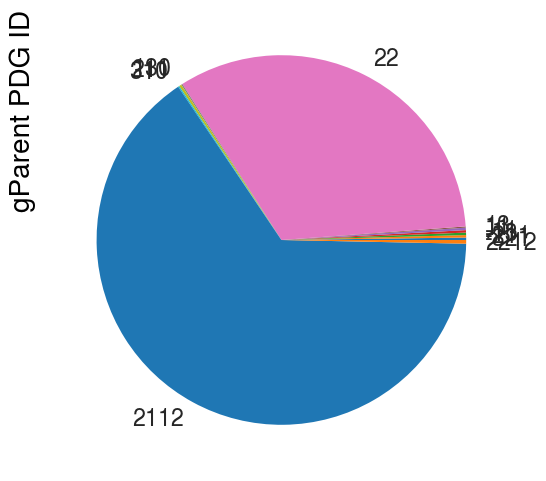

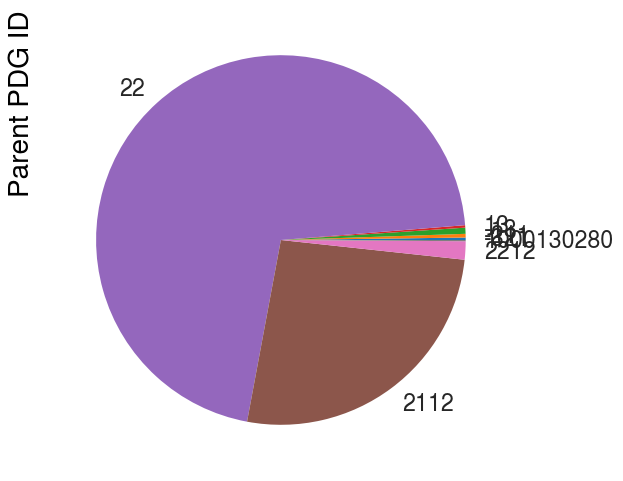

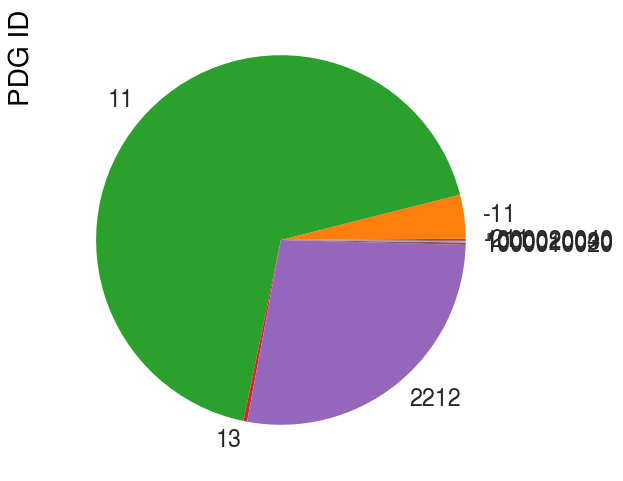

In [23]:
df_tmp.query('sampling_factor>10').groupby(['crvinfomc_gparentPdgId']).size().plot(kind='pie', y='crvinfomc_gparentPdgId')
plt.ylabel("gParent PDG ID")
plt.figure()
df_tmp.query('sampling_factor>10').groupby(['crvinfomc_parentPdgId']).size().plot(kind='pie', y='crvinfomc_parentPdgId')
plt.ylabel("Parent PDG ID")
plt.figure()
df_tmp.query('sampling_factor>10').groupby(['crvinfomc_pdgId']).size().plot(kind='pie', y='crvinfomc_pdgId')
plt.ylabel("PDG ID")

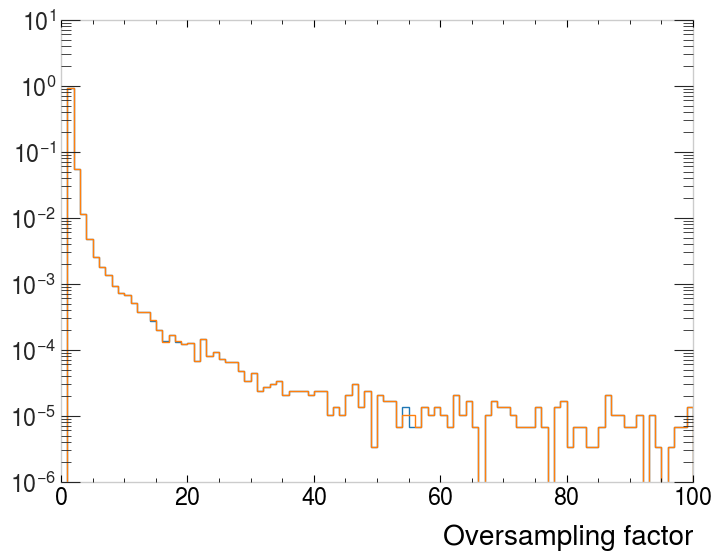

In [24]:
df_tmp = df.query('crvinfo_PEs>0').groupby(['crvinfomc_x',	'crvinfomc_y', 'crvinfomc_z', 'crvinfomc_parentX', 'crvinfomc_parentZ', 'crvinfomc_parentPdgId']).size().reset_index()[0]
#df_tmp = df.query('crvinfo_PEs>0').groupby(['crvinfomc_parentX', 'crvinfomc_parentZ', 'crvinfomc_parentPdgId']).size().reset_index()[0]
plt.hist(df_tmp, histtype='step', density=True, bins=100, range=(0, 100));
df_tmp = df.query('crvinfo_PEs>0').groupby(['crvinfomc_x',	'crvinfomc_y', 'crvinfomc_z', 'crvinfomc_parentX',]).size().reset_index()[0]
plt.hist(df_tmp, histtype='step', density=True, bins=100, range=(0, 100));
plt.xlabel('Oversampling factor')
plt.yscale('log')

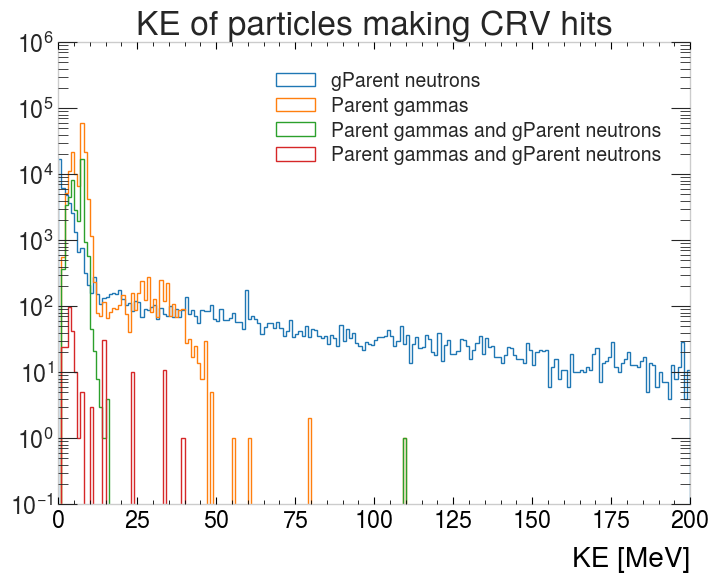

In [25]:
plt.hist(df.query(cut_extmom+'& crvinfomc_gparentPdgId==2112')['crvinfomc_gparentE'], range=(0, 200), bins=200, histtype='step', label='gParent neutrons');
plt.hist(df.query(cut_extmom+'& crvinfomc_parentPdgId==22')['crvinfomc_parentE'], range=(0, 200), bins=200, histtype='step', label='Parent gammas');
plt.hist(df.query(cut_extmom+'& crvinfomc_parentPdgId==22 & crvinfomc_gparentPdgId==2112')['crvinfomc_parentE'], range=(0, 200), bins=200, histtype='step', label='Parent gammas and gParent neutrons');
plt.hist(df.query(cut_extmom+'& crvinfomc_parentPdgId==22 & abs(crvinfomc_gparentPdgId)==11')['crvinfomc_parentE'], range=(0, 200), bins=200, histtype='step', label='Parent gammas and gParent neutrons');
plt.xlabel('KE [MeV]')
plt.title('KE of particles making CRV hits')
plt.legend()
plt.yscale('log')

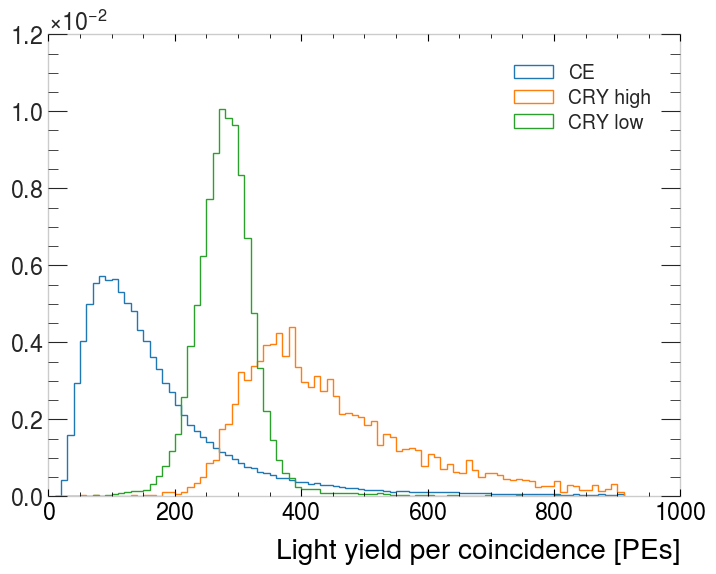

In [26]:
plt.figure()
label='Mean PE: %.1f'%(df.query(cut_extmom)['crvinfo_PEs'].mean())
plt.hist(df.query(cut_extmom)['crvinfo_PEs'], range=(10, 910), bins=90, histtype='step', label='CE', density=True);
plt.hist(dfCRY5.query(cut_extmom+'& is_high==1')['crvinfo_PEs'], range=(10, 910), bins=90, histtype='step', label='CRY high', density=True);
plt.hist(dfCRY5.query(cut_extmom+'& is_high==0')['crvinfo_PEs'], range=(10, 910), bins=90, histtype='step', label='CRY low', density=True);
plt.xlabel('Light yield per coincidence [PEs]')
plt.legend();

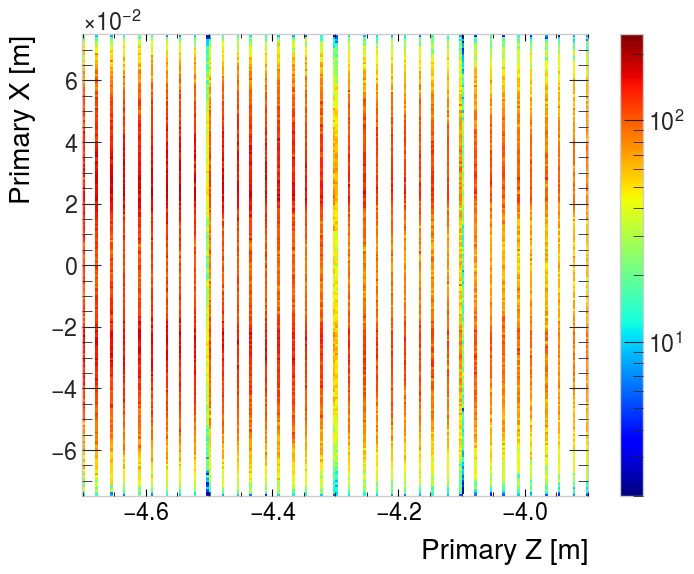

In [27]:

#fig, ax = plt.subplots()
h=plt.hist2d(df.query(cut_extmom)['demcpri_posZ']/1000, df.query(cut_extmom)['demcpri_posX']/1000, bins = 200, norm=mpl.colors.LogNorm(), cmap=plt.cm.jet);
plt.colorbar(h[3])
plt.xlabel('Primary Z [m]')
plt.ylabel('Primary X [m]');

#Calo variables

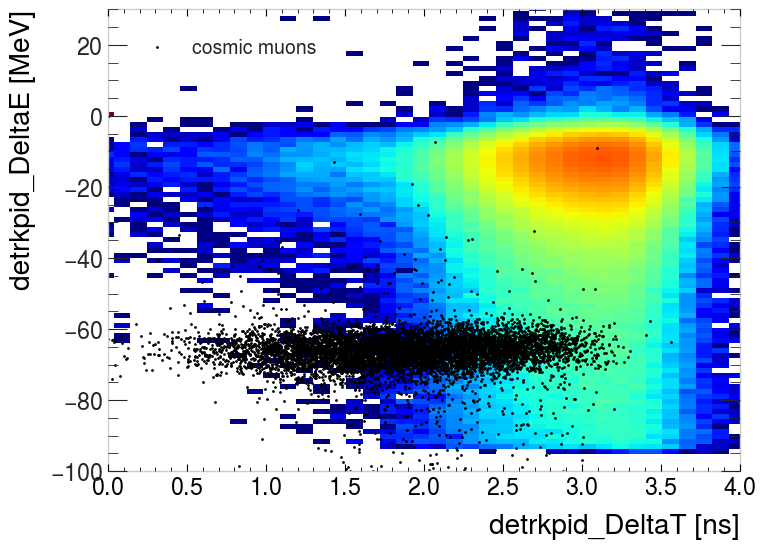

In [62]:
cut_tmp = cut_extmom+'& abs(demc_pdg) == 11'
plt.hist2d(df.query(cut_tmp)['detrkpid_DeltaT'], df.query(cut_tmp)['detrkpid_DeltaE'], bins = 100, norm=mpl.colors.LogNorm(), cmap=plt.cm.jet, label='CE');
cut_tmp = cut_extmom+'& abs(demc_pdg) == 13'
plt.plot(dfCRY5.query(cut_tmp)['detrkpid_DeltaT'], dfCRY5.query(cut_tmp)['detrkpid_DeltaE'], '.k', markersize='2.0', label='cosmic muons');

plt.xlabel('detrkpid_DeltaT [ns]')
plt.ylabel('detrkpid_DeltaE [MeV]')
plt.xlim(0,4)
plt.ylim(-100,30);
plt.legend(loc='upper left');

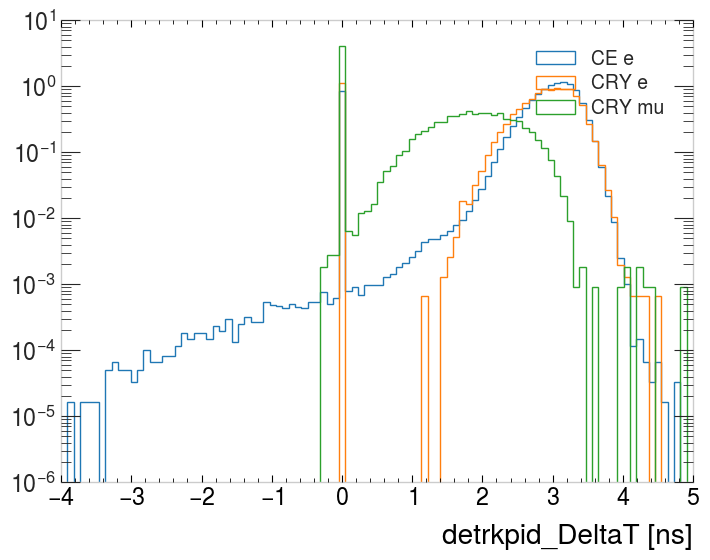

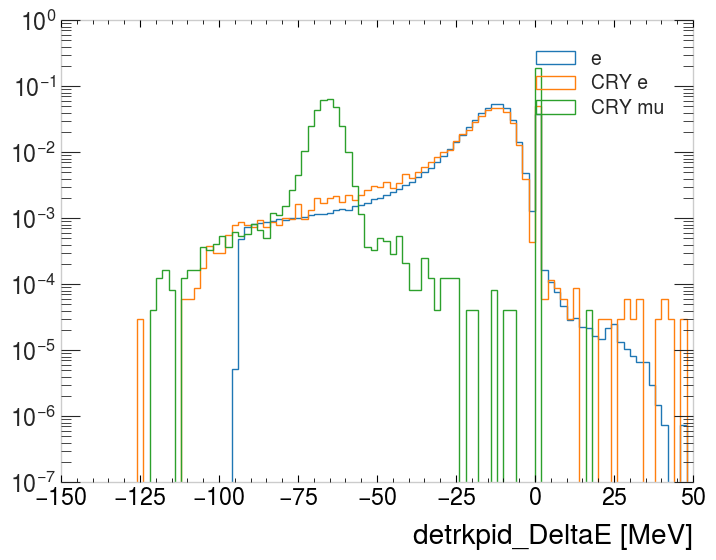

In [45]:
plt.figure()
plt.hist(df.query(cut_extmom+'& abs(demc_pdg) == 11')['detrkpid_DeltaT'], bins = 100, range=(-4,5), histtype='step', label='CE e', density=True);
plt.hist(dfCRY5.query(cut_extmom+'& abs(demc_pdg) == 11')['detrkpid_DeltaT'], bins = 100, range=(-4,5), histtype='step', label='CRY e', density=True);
plt.hist(dfCRY5.query(cut_extmom+'& abs(demc_pdg) == 13')['detrkpid_DeltaT'], bins = 100, range=(-4,5), histtype='step', label='CRY mu', density=True);
plt.xlabel('detrkpid_DeltaT [ns]')
plt.yscale('log')
plt.legend()

plt.figure()
plt.hist(df.query(cut_extmom+'& abs(demc_pdg) == 11 ')['detrkpid_DeltaE'], bins = 100, range=(-150,50), histtype='step', label='e', density=True);
plt.hist(dfCRY5.query(cut_extmom+'& abs(demc_pdg) == 11')['detrkpid_DeltaE'], bins = 100, range=(-150,50), histtype='step', label='CRY e', density=True);
plt.hist(dfCRY5.query(cut_extmom+'& abs(demc_pdg) == 13')['detrkpid_DeltaE'], bins = 100, range=(-150,50), histtype='step', label='CRY mu', density=True);
plt.xlabel('detrkpid_DeltaE [MeV]')
plt.yscale('log')
plt.legend()